In [1]:
# Reset variables
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import glob, os
import matplotlib as mpl
from shapely.geometry import Point, Polygon
from matplotlib.pyplot import figure

In [3]:
# I received this floater balloon from both of my stations, one in San Francisco and
# the other station in Los Gatos. I need to merge these two datasets into one dataframe

# This log file was received in San Francisco station, radiosonde_auto_rx version 1.4.1
df1 = pd.read_csv('20210312-204802_S3240385_RS41_404201_sonde.log')

# This log file was received by the Los Gatos station, radiosonde_auto_rx version 1.3.2
df2 = pd.read_csv('20210312-224417_S3240385_RS41_404201_sonde.log')

# Concatenate the two dataframes. This just adds the second dataframe (Los Gatos data)
# on to the end of the first dataframe (San Francisco data)
df3 = pd.concat([df1, df2], ignore_index=True)

# Since a particular packet was sometimes received by both stations, discard the second
# instance of that packet. In other words, throw out the duplicate Los Gatos data. Use
# the "frame" column to check for duplicates.
df4 = df3.drop_duplicates(subset='frame', keep='first')

# The dataframe has the unique Los Gatos data on the end, so resort the list based on
# Frame number. This is not needed for computer use, just for humans readability.
df5 = df4.sort_values(by='frame')
print(df5)

# Save this new dataframe to CSV. Note that the Index number (first column) will be
# out of order, due to the sorting for human readability
csv_data = df5.to_csv('S3240385_merged.csv', index=True)

                      timestamp    serial  frame       lat        lon  \
0      2021-03-12T20:48:18.000Z  S3240385   1035  37.73810 -122.22070   
1      2021-03-12T20:48:19.000Z  S3240385   1036  37.73805 -122.22069   
2      2021-03-12T20:48:20.000Z  S3240385   1037  37.73800 -122.22068   
3      2021-03-12T20:48:22.000Z  S3240385   1039  37.73787 -122.22064   
4      2021-03-12T20:48:24.000Z  S3240385   1041  37.73774 -122.22059   
...                         ...       ...    ...       ...        ...   
11262  2021-03-13T01:57:35.000Z  S3240385  19592  36.30184 -120.11572   
11263  2021-03-13T01:57:36.000Z  S3240385  19593  36.30185 -120.11564   
11264  2021-03-13T01:57:37.000Z  S3240385  19594  36.30187 -120.11557   
11265  2021-03-13T01:57:38.000Z  S3240385  19595  36.30189 -120.11549   
11266  2021-03-13T01:57:40.000Z  S3240385  19597  36.30193 -120.11535   

           alt  vel_v  vel_h  heading   temp  humidity  pressure      type  \
0        571.4    2.5    5.4    177.7 -273.0 

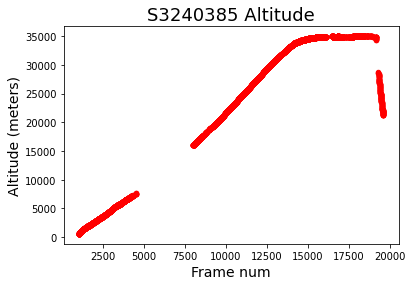

In [4]:
# Just a quick sanity check to see all the Altitude data
plot = df5.plot(kind='scatter',x='frame',y='alt',color='red')

plot.set_title('S3240385 Altitude', fontsize=18)
plot.set_ylabel('Altitude (meters)', fontsize=14)
plot.set_xlabel('Frame num', fontsize=14)
plt.savefig('S3240385_altitude.jpg', bbox_inches='tight')

In [5]:
# Insert another colum in the dataframe for "Hours since power on".
# Since we don't actually have the launch time, we will use the Frame
# number to approximate this. Frame number increments every second.

df5.insert(3, "hrs_since_poweron", (df5.frame/3600), True)

print(df5)

                      timestamp    serial  frame  hrs_since_poweron       lat  \
0      2021-03-12T20:48:18.000Z  S3240385   1035           0.287500  37.73810   
1      2021-03-12T20:48:19.000Z  S3240385   1036           0.287778  37.73805   
2      2021-03-12T20:48:20.000Z  S3240385   1037           0.288056  37.73800   
3      2021-03-12T20:48:22.000Z  S3240385   1039           0.288611  37.73787   
4      2021-03-12T20:48:24.000Z  S3240385   1041           0.289167  37.73774   
...                         ...       ...    ...                ...       ...   
11262  2021-03-13T01:57:35.000Z  S3240385  19592           5.442222  36.30184   
11263  2021-03-13T01:57:36.000Z  S3240385  19593           5.442500  36.30185   
11264  2021-03-13T01:57:37.000Z  S3240385  19594           5.442778  36.30187   
11265  2021-03-13T01:57:38.000Z  S3240385  19595           5.443056  36.30189   
11266  2021-03-13T01:57:40.000Z  S3240385  19597           5.443611  36.30193   

             lon      alt  

<AxesSubplot:xlabel='hrs_since_poweron', ylabel='vel_v'>

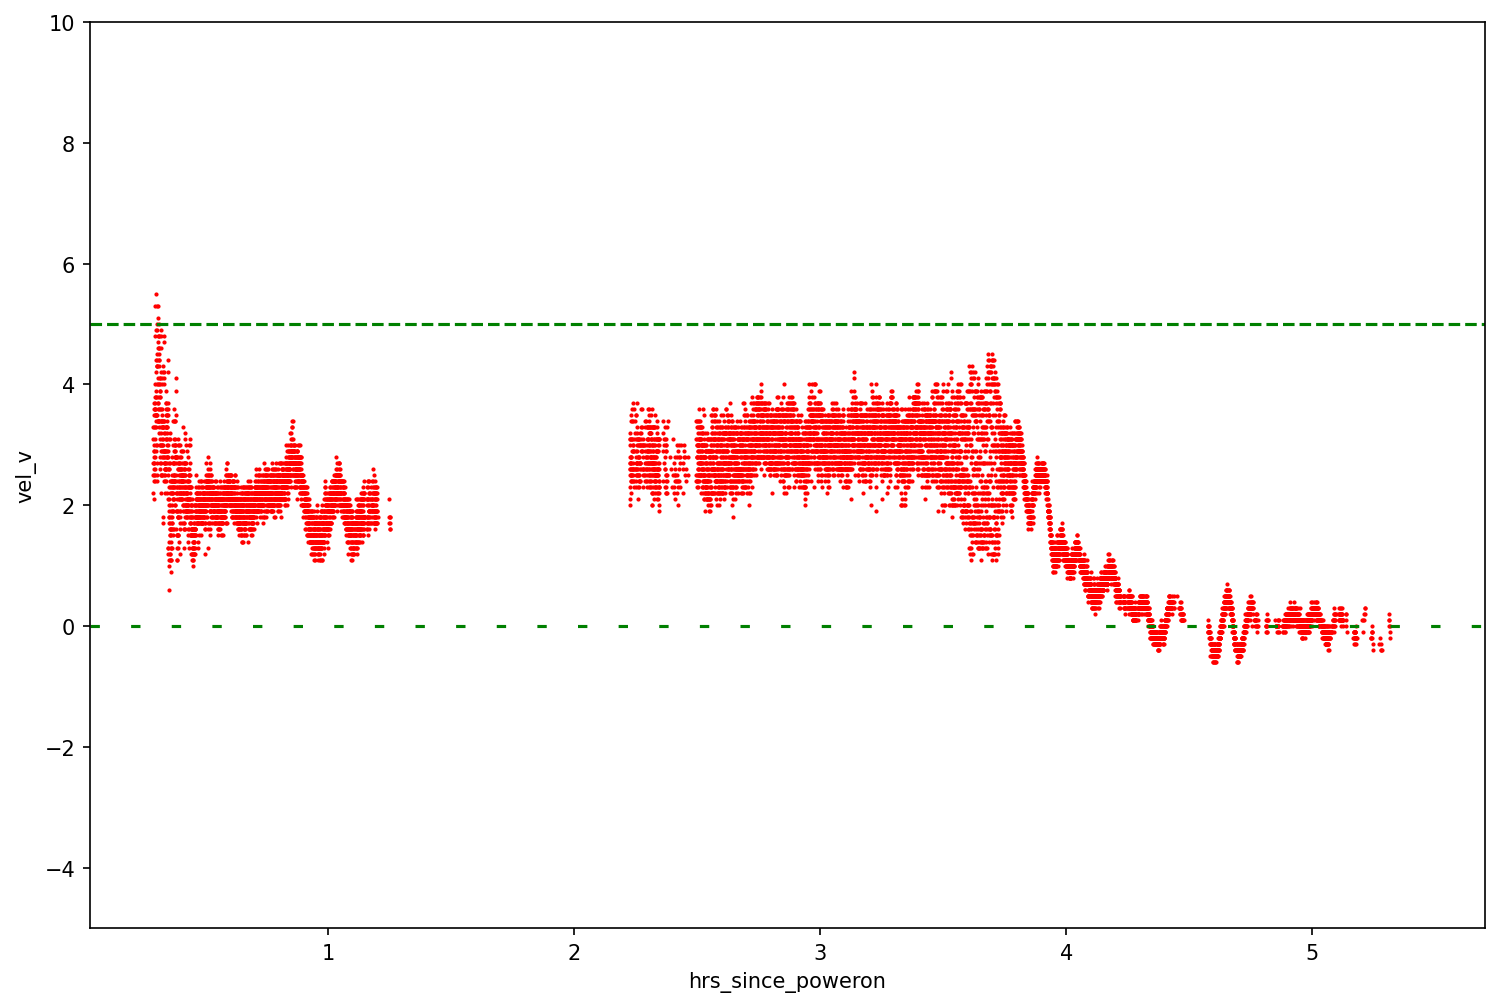

In [6]:
# Plot the vertical velocity of the balloon. Balloons target 5 m/s ascent
# rate, so draw some horizontal lines at 5 m/s and 0 m/s (neutrally bouyant)
fig = plt.figure(figsize=(12,8), dpi=150)

ax = fig.add_subplot(111)
ax.set_ylim([-5,10])
ax.axhline(y=5, color='green', linestyle='dashed')
ax.axhline(y=0, color='green', linestyle=(0, (3, 10)))
df5.plot.scatter(x='hrs_since_poweron',y='vel_v',s=1,color='red',ax=ax)


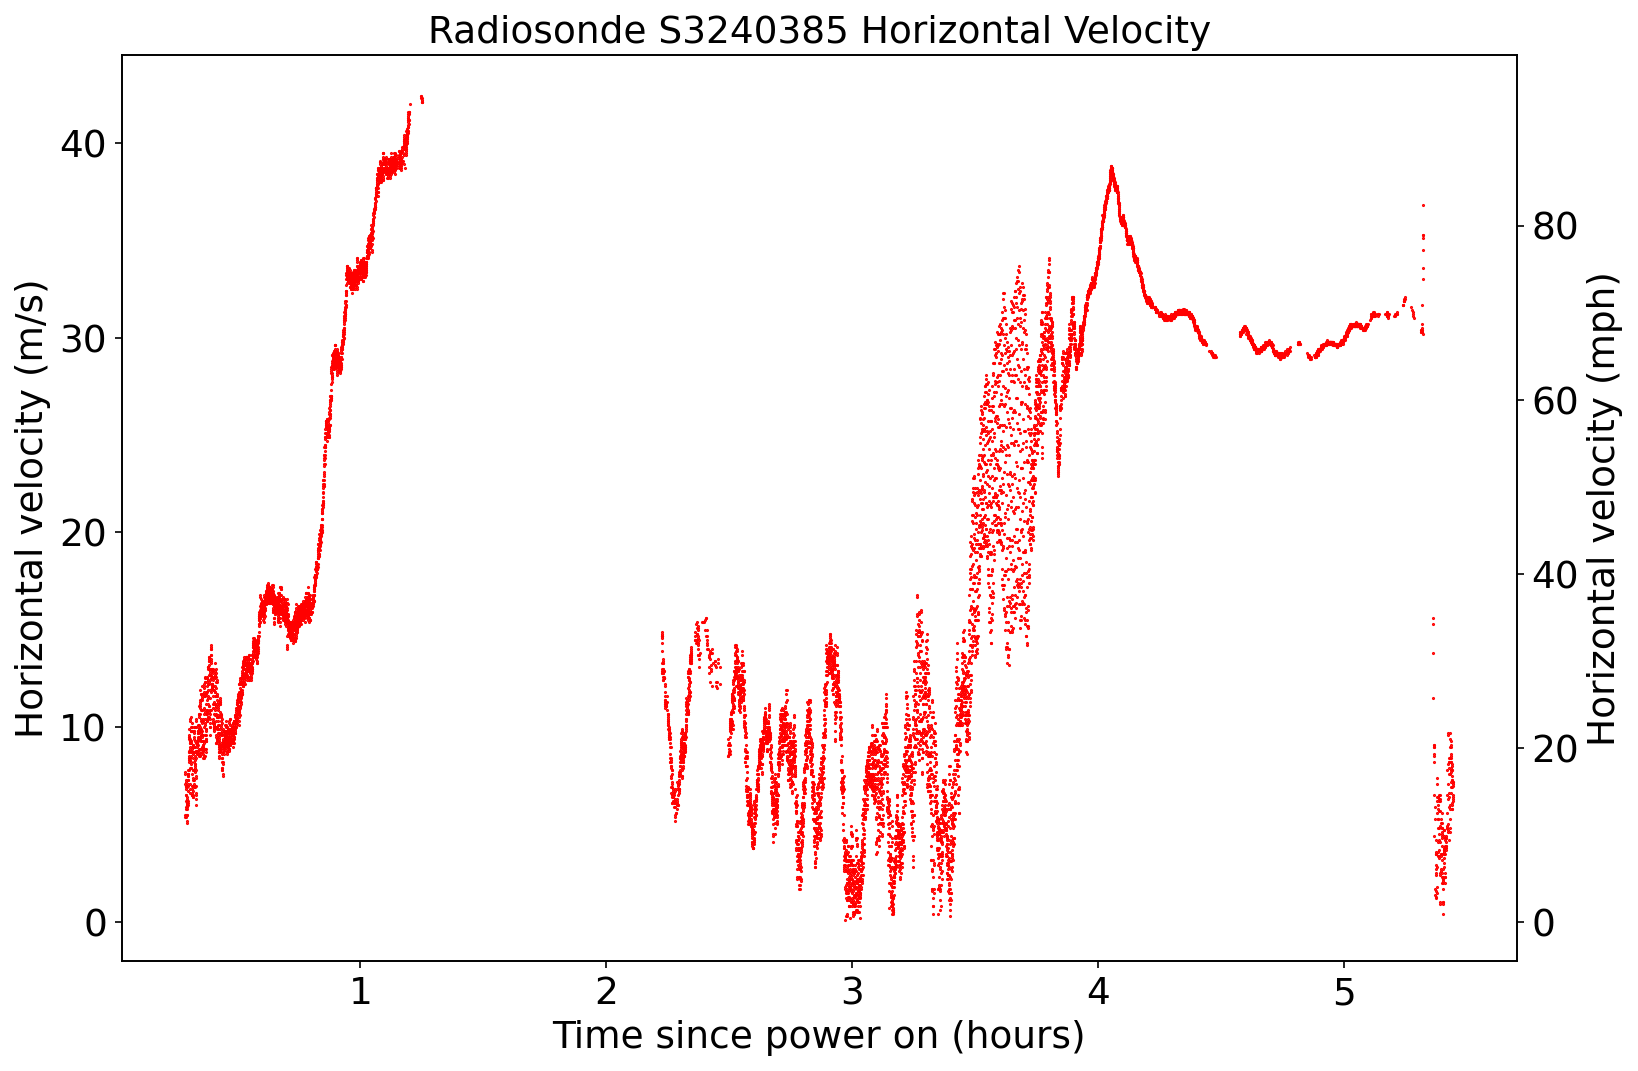

In [7]:
# Plot of horizontal velocity of balloon, with MPH also
fig = plt.figure(figsize=(12,8), dpi=150)
fig.patch.set_facecolor('white')

# Set up the axes
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()


ax1.scatter(x=df5['hrs_since_poweron'],y=df5['vel_h'], s=1, c='red', marker=".")
ax1.set_title('Radiosonde S3240385 Horizontal Velocity', fontsize=18)
ax1.set_ylabel('Horizontal velocity (m/s)', fontsize=18)
ax1.set_xlabel('Time since power on (hours)', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)


# Add a second axis with MPH instead of m/s
vel_mph = lambda vel_h: vel_h*2.237

# get left axis limits
ymin, ymax = ax1.get_ylim()
# apply function and set transformed values to right axis limits
ax2.set_ylim((vel_mph(ymin),vel_mph(ymax)))
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
ax2.plot([],[])

ax2.set_ylabel('Horizontal velocity (mph)', fontsize=18)
ax2.tick_params(axis='y', which='major', labelsize=18)


# Save the final plot
fig.savefig('S3240385_vel_mph.png', bbox_inches='tight')

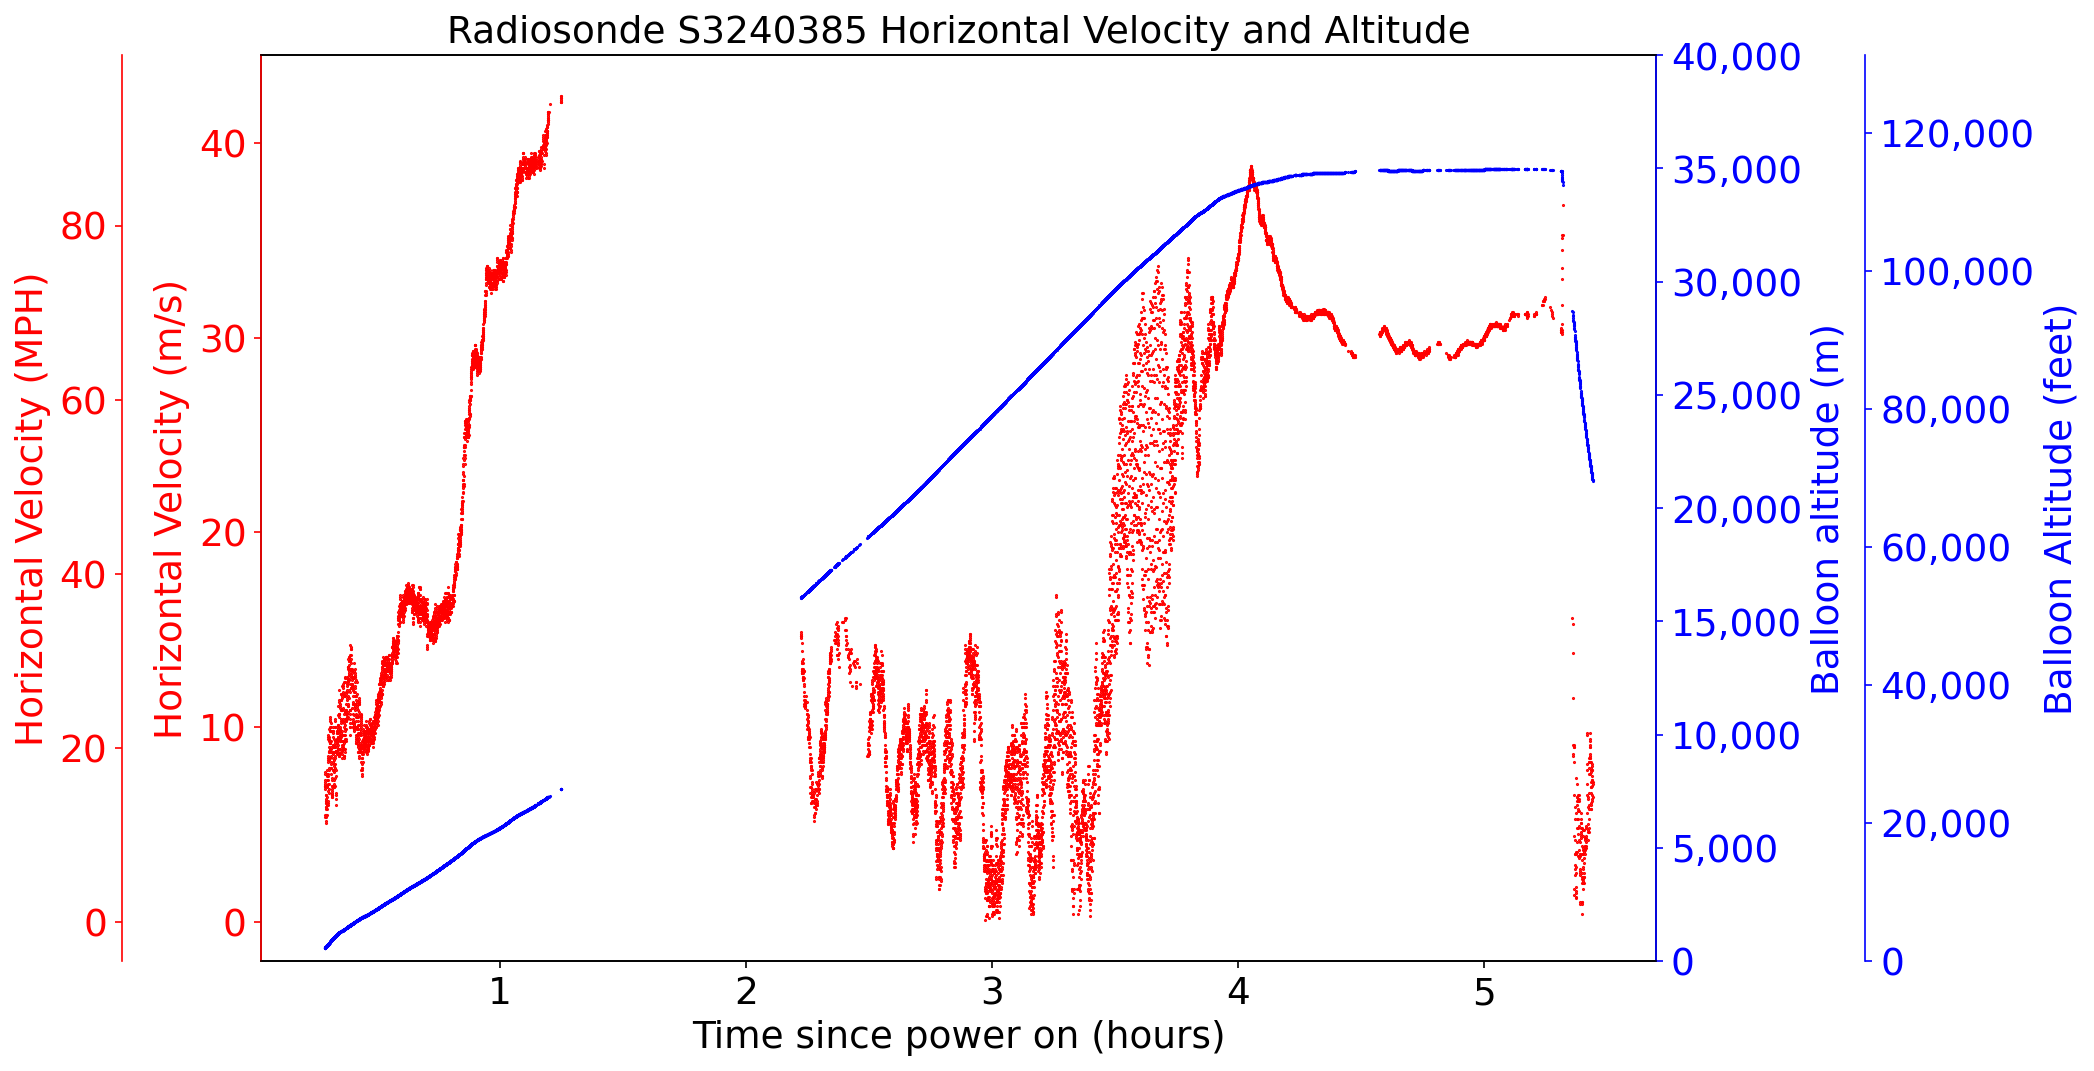

In [8]:
# Plot of horizontal rate and balloon altitude on one graph
fig = plt.figure(figsize=(12,8), dpi=150)
fig.patch.set_facecolor('white')

# Functions to convert 
vel_mph = lambda vel_h: vel_h*2.237
alt_feet = lambda alt: alt*3.281

# Set up the axes: Main axis ax1 has subplot ax2 (which is a twin axis)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# ax3 is a secondary axis of ax1, with functions
ax3 = ax1.secondary_yaxis(-0.1, functions=(vel_mph, vel_mph))
# ax4 is a secondary axis of ax2, with functions
ax4 = ax2.secondary_yaxis(1.15, functions=(alt_feet, alt_feet))


# Plot horiz velocity scatterplot on ax1
ax1.scatter(x=df5['hrs_since_poweron'],y=df5['vel_h'], s=1, c='red', marker=".")
# Colors and labels for ax1
ax1.set_title('Radiosonde S3240385 Horizontal Velocity and Altitude', fontsize=18)
ax1.set_ylabel('Horizontal Velocity (m/s)', fontsize=18)
ax1.set_xlabel('Time since power on (hours)', fontsize=18)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
ax1.tick_params(axis='both', which='major', labelsize=18)


# Plot altitude scatterplot on twin axis ax2
ax2.scatter(x=df5['hrs_since_poweron'],y=df5['alt'], s=1, c='blue', marker=".")
# Set colors and labels for twin axis ax2
ax2.set_ylabel('Balloon altitude (m)', fontsize=18)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim([0,40000])
ax2.tick_params(axis='y', which='major', labelsize=18)


# ax3 is generated above as the Secondary Axis of ax1
# Colors and labels for 3rd axis
ax3.tick_params(axis='y', colors='red')
ax3.spines['left'].set_color('red')
ax3.yaxis.label.set_color('red')
ax3.set_ylabel('Horizontal Velocity (MPH)', fontsize=18)
ax3.tick_params(axis='y', which='major', labelsize=18)


# ax4 is generated above as the Secondary Axis of ax2
# Colors and labels for 4th axis
ax4.tick_params(axis='y', colors='blue')
ax4.spines['right'].set_color('blue')
ax4.yaxis.label.set_color('blue')
ax4.set_ylabel('Balloon Altitude (feet)', fontsize=18)
ax4.tick_params(axis='y', which='major', labelsize=18)
ax4.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))


# Save the final plot
fig.savefig('S3240385_velocity_MPH_feet.png', bbox_inches='tight')

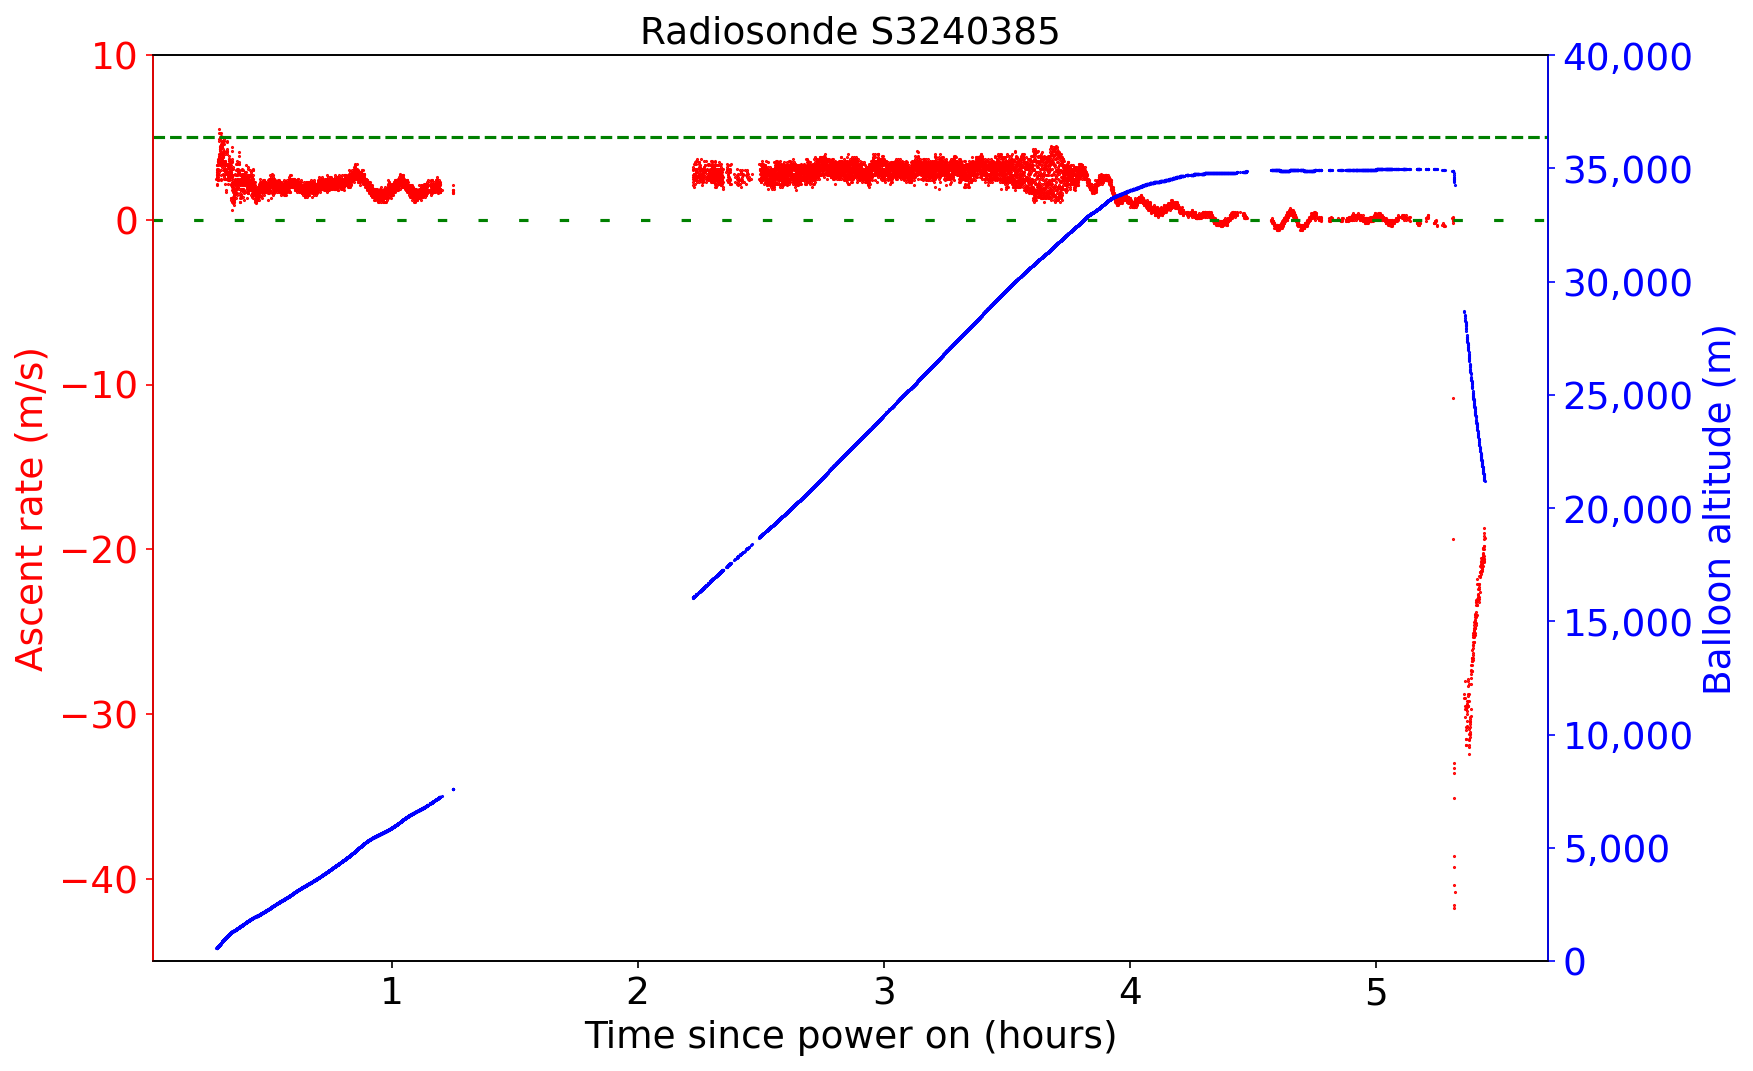

In [9]:
# Plot of ascent rate and balloon altitude on one graph
fig = plt.figure(figsize=(12,8), dpi=150)
fig.patch.set_facecolor('white')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.scatter(x=df5['hrs_since_poweron'],y=df5['vel_v'], s=1, c='red', marker=".", label='velocity')
ax1.set_title('Radiosonde S3240385', fontsize=18)
ax1.set_ylabel('Ascent rate (m/s)', fontsize=18)
ax1.set_xlabel('Time since power on (hours)', fontsize=18)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
ax1.axhline(y=5, color='green', linestyle='dashed')
ax1.axhline(y=0, color='green', linestyle=(0, (3, 10)))
ax1.set_ylim([-45,10])
ax1.tick_params(axis='both', which='major', labelsize=18)

ax2.scatter(x=df5['hrs_since_poweron'],y=df5['alt'], s=1, c='blue', marker=".", label='alt')
ax2.set_ylabel('Balloon altitude (m)', fontsize=18)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim([0,40000])
ax2.tick_params(axis='y', which='major', labelsize=18)


# Save the final plot
fig.savefig('S3240385_ascent_altitude.png', bbox_inches='tight')

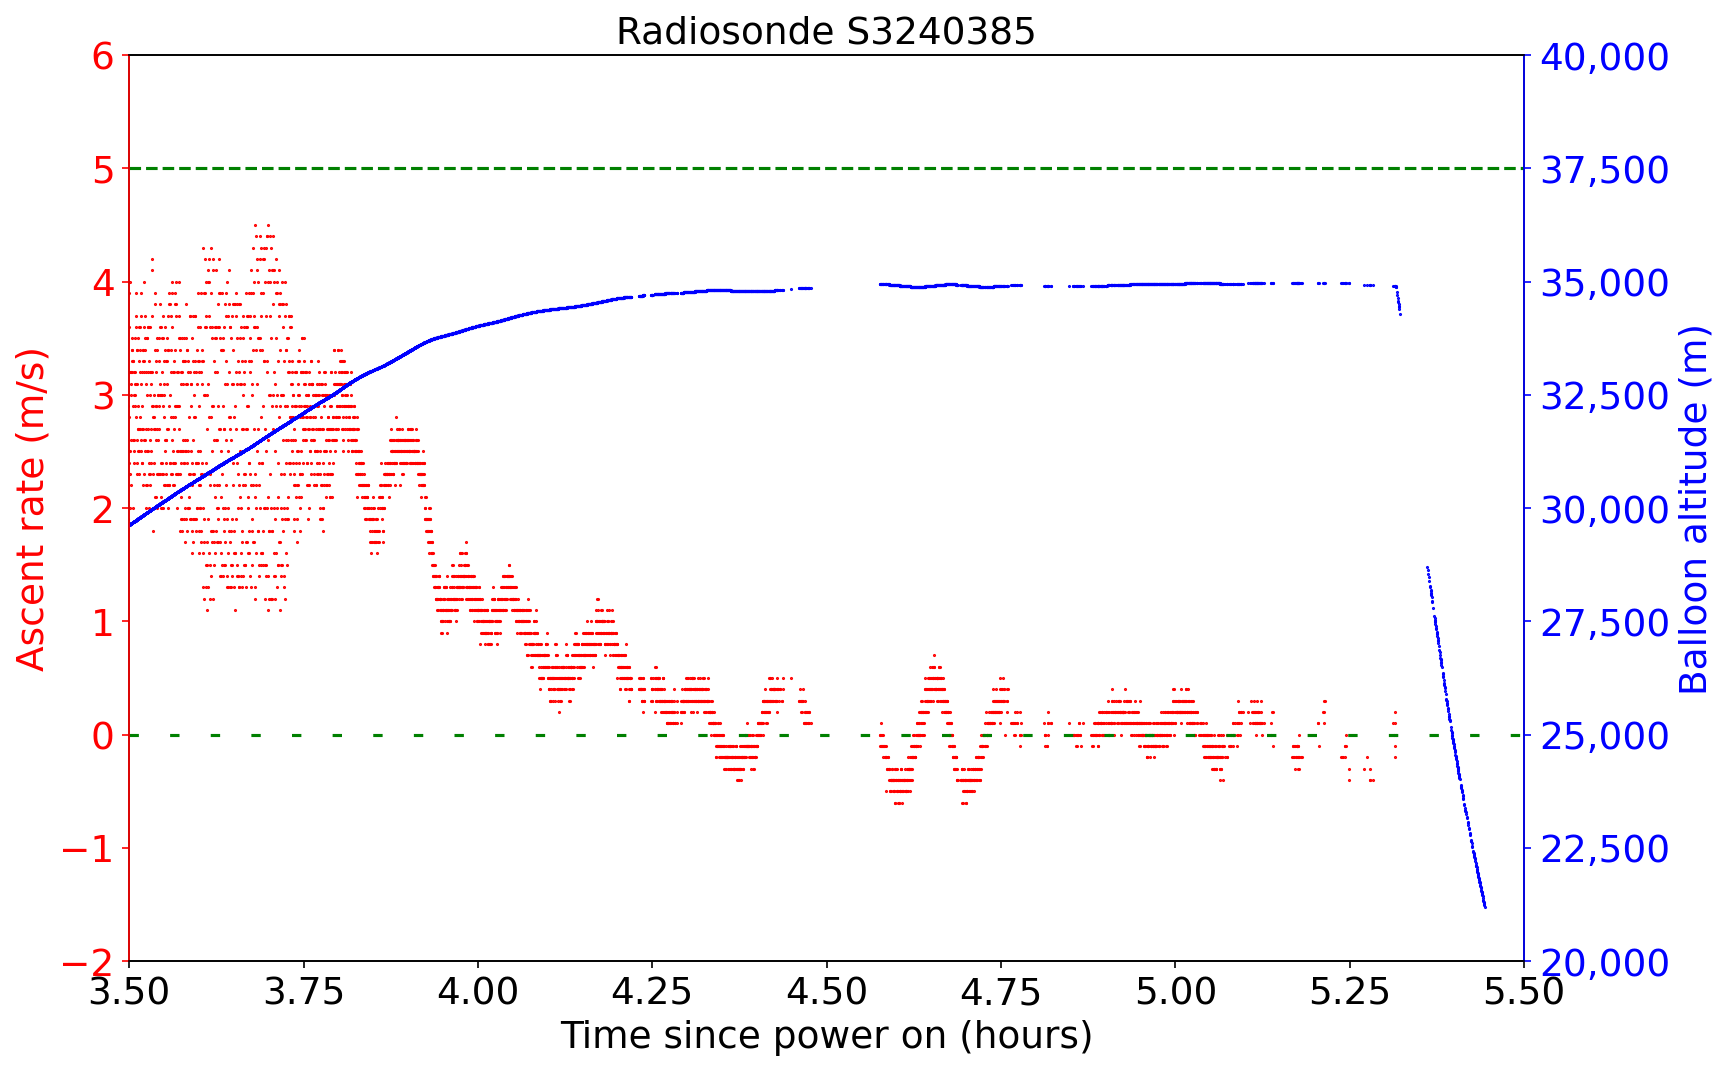

In [10]:
# Zoom plot of ascent rate and balloon altitude on one graph
fig = plt.figure(figsize=(12,8), dpi=150)
fig.patch.set_facecolor('white')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.scatter(x=df5['hrs_since_poweron'],y=df5['vel_v'], s=1, c='red', marker=".", label='velocity')
ax1.set_title('Radiosonde S3240385', fontsize=18)
ax1.set_ylabel('Ascent rate (m/s)', fontsize=18)
ax1.set_xlabel('Time since power on (hours)', fontsize=18)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
ax1.axhline(y=5, color='green', linestyle='dashed')
ax1.axhline(y=0, color='green', linestyle=(0, (3, 10)))
ax1.set_ylim([-2,6])
ax1.set_xlim([3.5,5.5])

ax1.tick_params(axis='both', which='major', labelsize=18)

ax2.scatter(x=df5['hrs_since_poweron'],y=df5['alt'], s=1, c='blue', marker=".", label='alt')
ax2.set_ylabel('Balloon altitude (m)', fontsize=18)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim([20000,40000])
ax2.tick_params(axis='y', which='major', labelsize=18)

# Save the final plot
fig.savefig('S3240385_ascent_altitude_zoom.png', bbox_inches='tight')

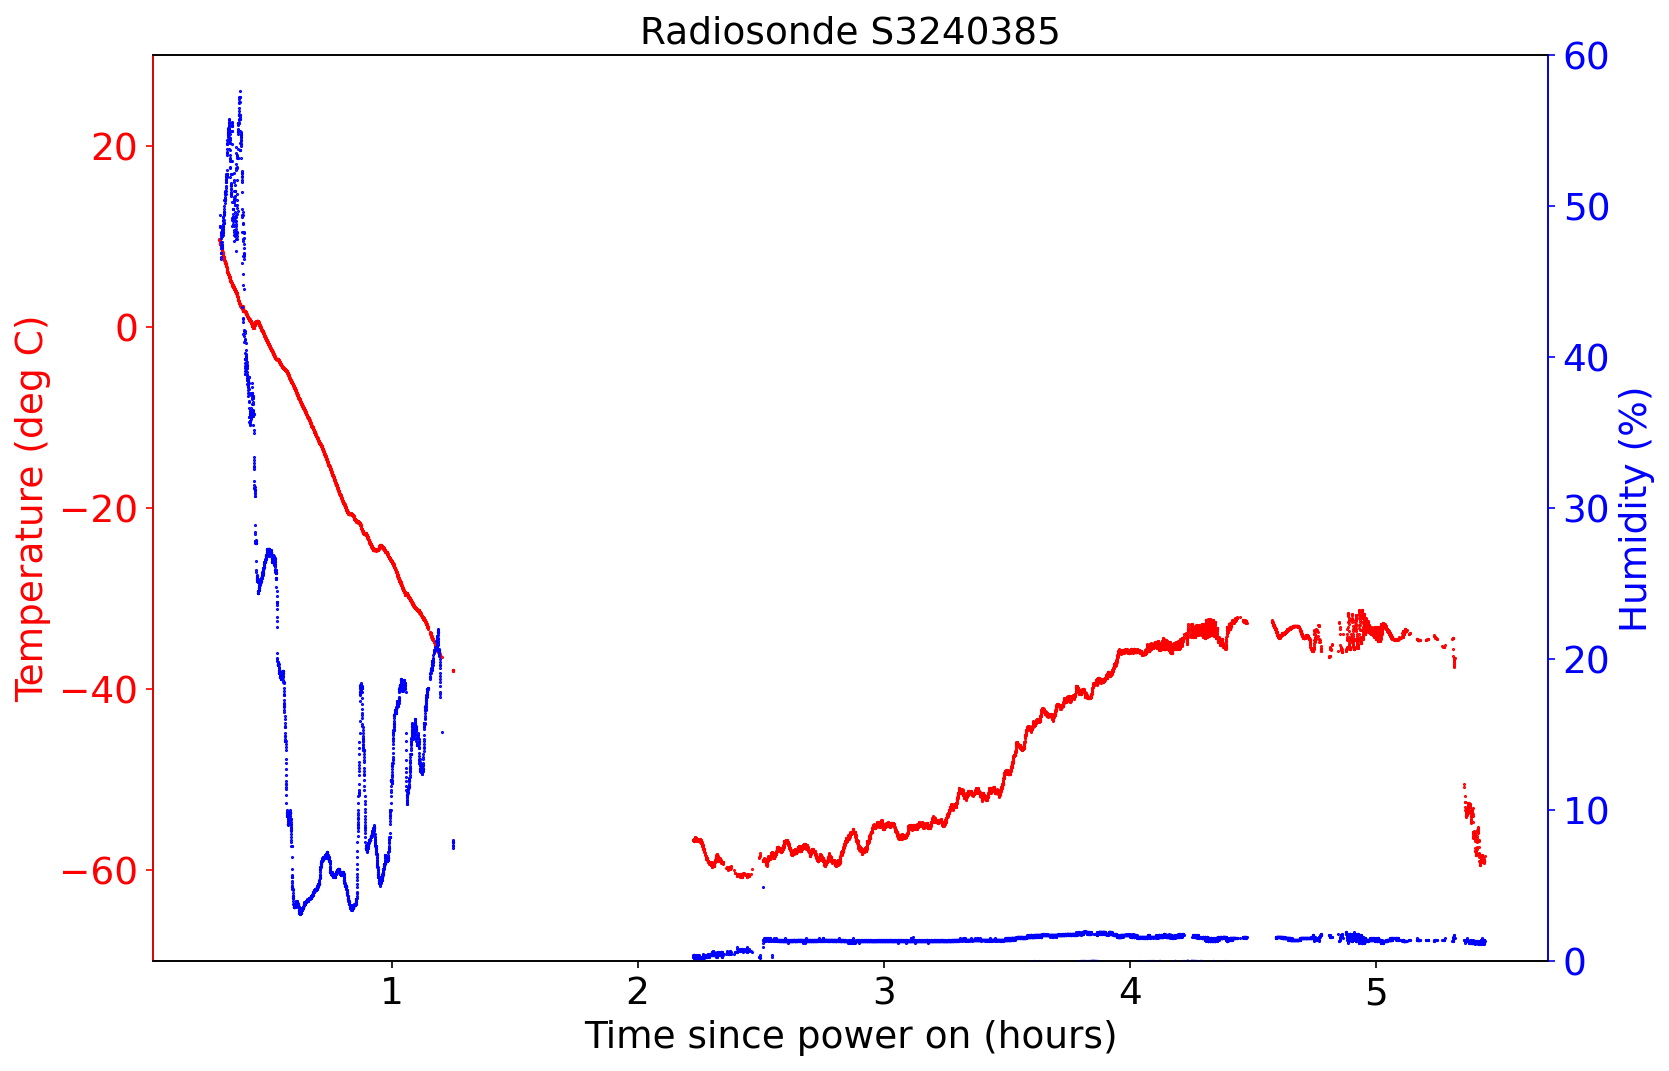

In [11]:
# Plot of temperature and humidity on one graph
fig = plt.figure(figsize=(12,8), dpi=150)
fig.patch.set_facecolor('white')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.scatter(x=df5['hrs_since_poweron'],y=df5['temp'], s=1, c='red', marker=".", label='velocity')
ax1.set_title('Radiosonde S3240385', fontsize=18)
ax1.set_ylabel('Temperature (deg C)', fontsize=18)
ax1.set_xlabel('Time since power on (hours)', fontsize=18)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
ax1.set_ylim([-70,30])
ax1.tick_params(axis='both', which='major', labelsize=18)

ax2.scatter(x=df5['hrs_since_poweron'],y=df5['humidity'], s=1, c='blue', marker=".", label='alt')
ax2.set_ylabel('Humidity (%)', fontsize=18)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim([0,60])
ax2.tick_params(axis='y', which='major', labelsize=18)


# Save the final plot
fig.savefig('S3240385_temp_humidity.png', bbox_inches='tight')

In [12]:
# Now on to plotting the lat/long of the balloon on a map

# Generate a geometry list of all the lat/long points in the dataframe
geometry = [Point(xy) for xy in zip( df5["lon"], df5["lat"]) ]
geometry[:3]

In [13]:
# Create a geopandas dataframe, using the pandas dataframe and the geometry points
geo_df = gpd.GeoDataFrame(df5,                 #specify data
                         crs = 'EPSG:4326',    #specify coordinate ref system
                         geometry = geometry)  #specify geometry list created

# Show a snippet of this dataframe
geo_df.head()

timestamp    serial  frame  hrs_since_poweron       lat  \
0  2021-03-12T20:48:18.000Z  S3240385   1035           0.287500  37.73810   
1  2021-03-12T20:48:19.000Z  S3240385   1036           0.287778  37.73805   
2  2021-03-12T20:48:20.000Z  S3240385   1037           0.288056  37.73800   
3  2021-03-12T20:48:22.000Z  S3240385   1039           0.288611  37.73787   
4  2021-03-12T20:48:24.000Z  S3240385   1041           0.289167  37.73774   

         lon    alt  vel_v  vel_h  heading  ...  pressure  type  freq_mhz  \
0 -122.22070  571.4    2.5    5.4    177.7  ...      -1.0  RS41   404.201   
1 -122.22069  574.0    2.7    5.5    171.8  ...      -1.0  RS41   404.201   
2 -122.22068  576.4    2.2    7.1    168.2  ...      -1.0  RS41   404.201   
3 -122.22064  581.7    3.1    7.7    167.6  ...      -1.0  RS41   404.201   
4 -122.22059  588.4    3.3    7.6    170.1  ...      -1.0  RS41   404.201   

    snr  f_error_hz  sats  batt_v  burst_timer  aux_data  \
0  17.4           0     9     3.0           -1        -1   
1  15.8           0     9     3.0           -1        -1   
2  15.5           0     8     3.0           -1        -1   
3  15.6           0     9     3.0           -1        -1   
4  20.8           0    10     3.0           -1        -1   

                      geometry  
0  POINT (-122.22070 37.73810)  
1  POINT (-122.22069 37.73805)  
2  POINT (-122.22068 37.73800)  
3  POINT (-122.22064 37.73787)  
4  POINT (-122.22059 37.73774)  

[5 rows x 22 columns]

<AxesSubplot:>

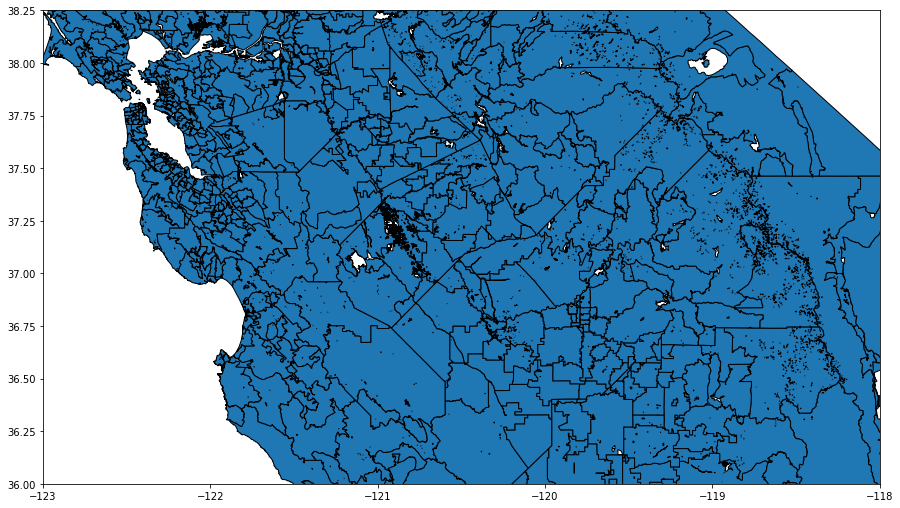

In [14]:
# Create the basemap of the area. The original shapefile are census areas in California.
# Also need .shx and .prj files in the same folder
census_map = gpd.read_file('TG00CAZCTA.shp')

# The census map's shapefile is using UTM coordinates for all the points. This changes the 
# Coordinate Reference System to WGS84 lat/lon, which is what the radiosonde telemetry is in
census_map = census_map.to_crs('EPSG:4326')

# Create a plot, set some lat/long limits, and plot it
fig,ax = plt.subplots(figsize = (15,15))
ax.set_ylim([36, 38.25])
ax.set_xlim([-123, -118])
census_map.plot(ax = ax, linewidth=1, edgecolor='black')

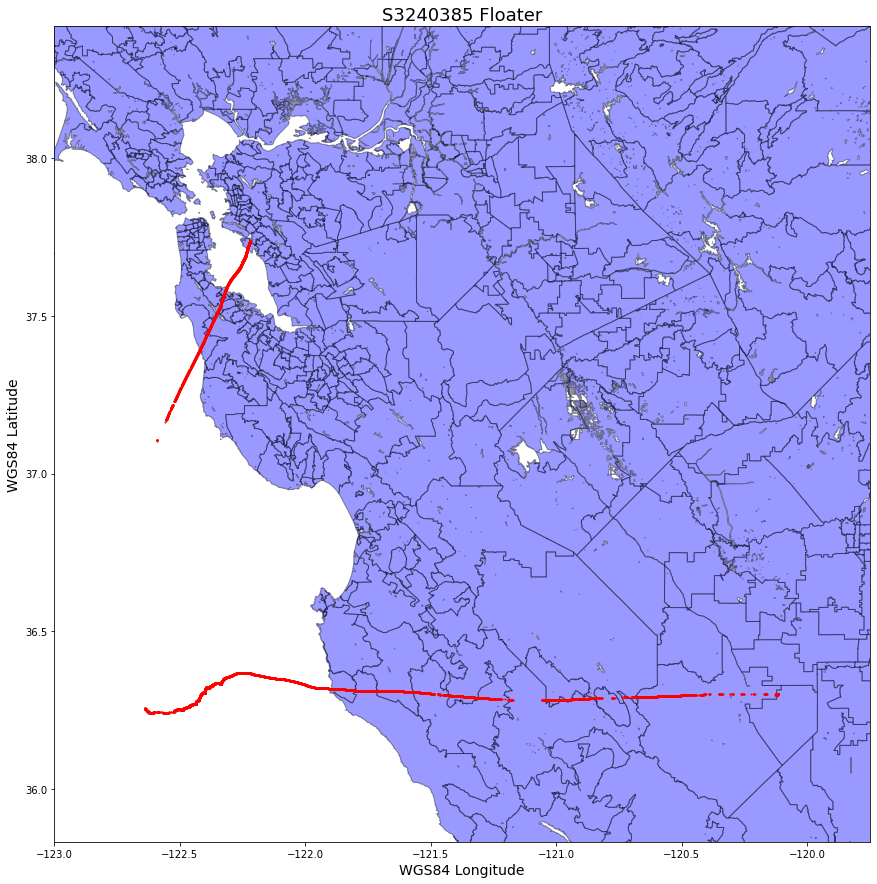

In [15]:
# Set up some limits for the map
fig,ax = plt.subplots(figsize = (15,15))
fig.patch.set_facecolor('white')

ax.set_box_aspect(1)
ax.set_ylim([36, 38.25])
ax.set_xlim([-123, -119.75])
ax.set_ylabel('WGS84 Latitude', fontsize=14)
ax.set_xlabel('WGS84 Longitude', fontsize=14)
ax.set_title('S3240385 Floater', fontsize=18)
census_map.plot(ax = ax, alpha = 0.4, color="blue", linewidth=1, edgecolor='black')

# Now actually plot the geopandas dataframe.
geo_df.plot(ax = ax, markersize = 1, color = "red", marker = "o")

plt.savefig('S3240385_float.png', bbox_inches='tight')